In [2]:
import numpy as np
import matplotlib.pyplot as plt
import librosa as lr
from sklearn.preprocessing import MinMaxScaler
from pathlib import Path
from scipy.ndimage import uniform_filter1d
import IPython.display as ipd

# Import samples
kick_samples = [lr.load(p)[0] for p in Path().glob('../data/Kicks/*.wav')]
sr = [lr.load(p)[1] for p in Path().glob('../data/Kicks/*.wav')]

def extract_features(signal,sr):
    return [
        # np.mean(lr.feature.zero_crossing_rate(signal)[0]),
        lr.feature.spectral_centroid(y=signal)[0,0],
        # lr.feature.spectral_bandwidth(y=signal)[0,0]
        # lr.feature.spectral_contrast(y=signal)[0,0],
        # lr.feature.spectral_flatness(y=signal)[0,0]
        # attack_time(signal),
        decay_time(signal)
    ]

def attack_time(signal):
    rms = lr.feature.rms(y=signal, frame_length=856, hop_length=40)
    times = lr.frames_to_time(np.arange(len(rms[0])), hop_length=40)
    rms = uniform_filter1d(rms, size=5)
    peak_index = np.argmax(rms[0][:1000])
    return times[peak_index]
    

def decay_time(signal):
    rms = lr.feature.rms(y=signal, frame_length=856, hop_length=40)
    times = lr.frames_to_time(np.arange(len(rms[0])), hop_length=40)
    rms = uniform_filter1d(rms, size=5)
    peak_index = np.argmax(rms)
    decay_threshold = rms[0][peak_index] * 0.1
    decay_index = peak_index + np.argmax(rms[0][peak_index:] < decay_threshold) # Get index at which amplitude has fallen to 30% of peak
    decay_time = times[decay_index] - times[peak_index]
    return decay_time

plt.figure(figsize=(5,14))

kick_features = np.array([extract_features(x,sr) for x in kick_samples])

scaler = MinMaxScaler((0,1))
scaled_features = scaler.fit_transform(kick_features[:,:])

# weights = np.array([1,0.2,0.8])
weighted_features = scaled_features * 1

<Figure size 500x1400 with 0 Axes>

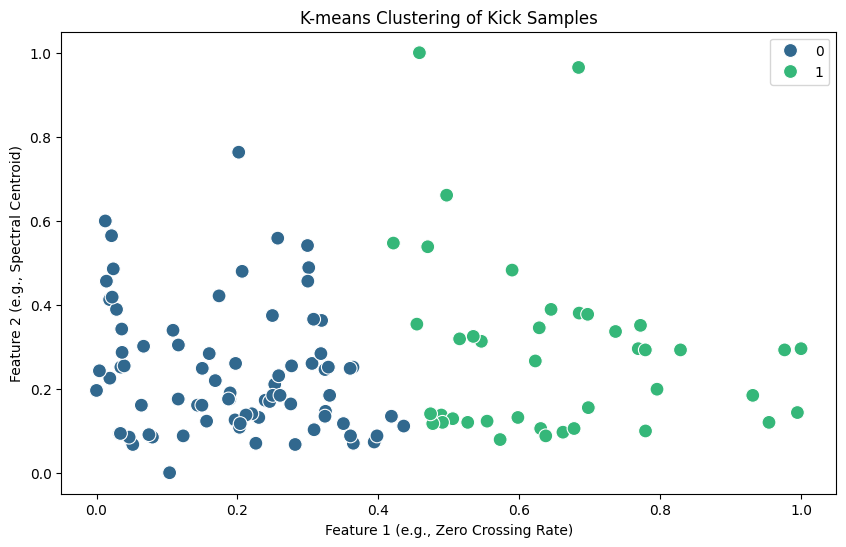

In [12]:
from sklearn.cluster import KMeans
import seaborn as sns

# Apply K-means clustering
n_clusters = 2  # You can change this based on how many different types of kicks you expect
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
labels = kmeans.fit_predict(scaled_features)

# Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=scaled_features[:, 0], y=scaled_features[:, 1], hue=labels, palette='viridis', s=100)
plt.xlabel('Feature 1 (e.g., Zero Crossing Rate)')
plt.ylabel('Feature 2 (e.g., Spectral Centroid)')
plt.title('K-means Clustering of Kick Samples')
plt.show()

In [8]:
import numpy as np
from sklearn.metrics import pairwise_distances

selected_sample_index = 7

# Calculate similarity within the cluster
similarity_scores = pairwise_distances(weighted_features)
sorted_indices = np.argsort(similarity_scores[selected_sample_index])  # Sort by highest similarity

sample_choices = [23,24,42,29,35]
# sample_choices[0]
sorted_indices

array([  7,  52, 116, 120,   8,  60,  11,   0,  44,   3, 110,   6,  45,
        22, 112,  28, 114,  12,  58, 106,  75, 102, 104,  65,  62,  47,
        97,  15,  81,  23, 119,  85,  57,  20, 111,  63,  51,  82, 108,
        14, 107,   9,  17, 113,  40, 101, 103,  31, 117,  13,  91,  32,
        37,  72,  27,  54,  24,  49,  33,  34,  83,  56,   2,  71,  99,
        25,  87,  10,  36,  73,  68,  90,  66,  78,  79,   5,  84,  48,
        77,  96,  61,  53,  92,  94,  39, 109,  89,  74, 100,  70,  46,
        55,  19, 118,  59,  86,  93,  29, 105,  95,   1,  41,  38,  80,
        50,  76,  64,  16,  67,  35,  26, 121,  69,  43,  21, 115,   4,
        98,  18,  30,  88,  42])

In [11]:
sample = kick_samples[116]
ipd.Audio(sample,rate=sr[0])

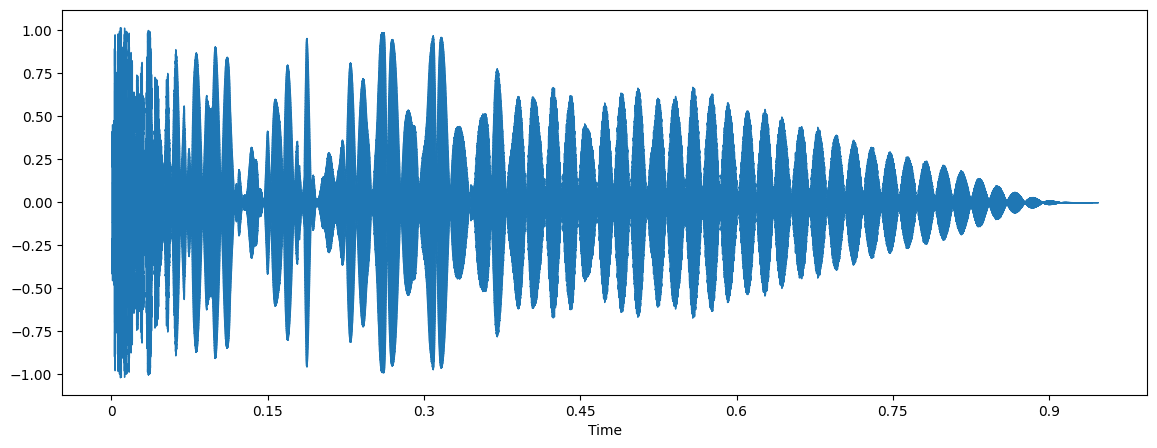

In [6]:
plt.figure(figsize=(14,5))
lr.display.waveshow(sample,sr=sr[0])

/var/folders/sb/r5rwz48d2jx0pdj_t3m2642w0000gn/T/ipykernel_72165/980224814.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


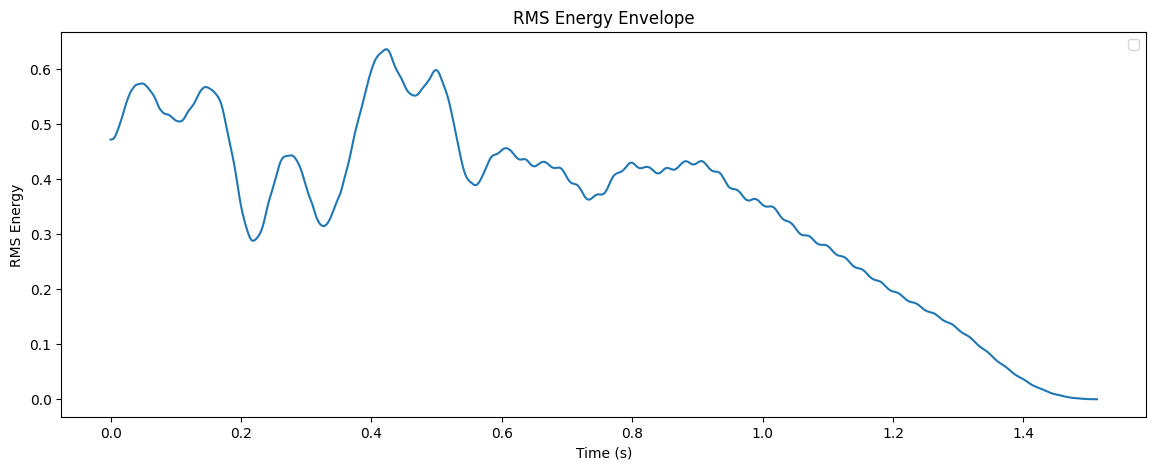

In [7]:
plt.figure(figsize=(14,5))
rms = lr.feature.rms(y=sample, frame_length=856, hop_length=30)
rms = uniform_filter1d(rms, size=20)
times = lr.frames_to_time(np.arange(len(rms[0])),sr=sr[0],hop_length=48)
plt.plot(times,rms[0])
plt.xlabel('Time (s)')
plt.ylabel('RMS Energy')
plt.title('RMS Energy Envelope')
plt.legend()
plt.show()
